In [1]:
%matplotlib inline

import os
import numpy as np 
import pandas as pd
from glob import glob

USE_CV2 = False
if USE_CV2:
    from cv2 import imread # opencv is much faster, but less accurate
    MIN_OBJ_VAL = 0
else:
    from skimage.io import imread
    MIN_OBJ_VAL = 1000


import matplotlib.image as mpimg
import matplotlib.pyplot as plt

KERAS_BACKEND='tensorflow'

from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Dropout, Conv2D, Cropping2D, Conv2DTranspose, Add, Input, Reshape, Permute, Activation
from keras.callbacks import ModelCheckpoint



/home/faisal/anaconda3/envs/ai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Data path used in this notebook. 

DATA_DIR = os.path.join('.', 'data')
TRAIN_IMAGE_DIR = os.path.join(DATA_DIR, 'Train/CameraRGB')
TRAIN_LABEL_DIR = os.path.join(DATA_DIR, 'Train/CameraSeg')

clara_seg_data = pd.DataFrame(dict(image = glob(os.path.join(TRAIN_IMAGE_DIR, '*.*p*g'))))
clara_seg_data['id'] = clara_seg_data['image'].map(lambda x: x.split('/')[-1].split('.')[0])
clara_seg_data['label'] = clara_seg_data['image'].map(lambda x: os.path.join(TRAIN_LABEL_DIR, x.split('/')[-1]))
clara_seg_data.sample(5)

,image,id,label
974,./data/Train/CameraRGB/183.png,183,./data/Train/CameraSeg/183.png
716,./data/Train/CameraRGB/880.png,880,./data/Train/CameraSeg/880.png
449,./data/Train/CameraRGB/637.png,637,./data/Train/CameraSeg/637.png
719,./data/Train/CameraRGB/694.png,694,./data/Train/CameraSeg/694.png
817,./data/Train/CameraRGB/418.png,418,./data/Train/CameraSeg/418.png


In [3]:
split = int(clara_seg_data.shape[0] *.20)
train_df, valid_df = clara_seg_data[0:-split], clara_seg_data[-split:]

print(train_df.head())


                            image   id                           label
0  ./data/Train/CameraRGB/804.png  804  ./data/Train/CameraSeg/804.png
1  ./data/Train/CameraRGB/793.png  793  ./data/Train/CameraSeg/793.png
2  ./data/Train/CameraRGB/512.png  512  ./data/Train/CameraSeg/512.png
3  ./data/Train/CameraRGB/862.png  862  ./data/Train/CameraSeg/862.png
4   ./data/Train/CameraRGB/37.png   37   ./data/Train/CameraSeg/37.png


In [4]:
from sklearn.utils import shuffle

train_df = shuffle(train_df)
valid_df = shuffle(valid_df)

print(train_df.head())


                              image   id                           label
367  ./data/Train/CameraRGB/979.png  979  ./data/Train/CameraSeg/979.png
632  ./data/Train/CameraRGB/710.png  710  ./data/Train/CameraSeg/710.png
635  ./data/Train/CameraRGB/889.png  889  ./data/Train/CameraSeg/889.png
276  ./data/Train/CameraRGB/738.png  738  ./data/Train/CameraSeg/738.png
96   ./data/Train/CameraRGB/379.png  379  ./data/Train/CameraSeg/379.png


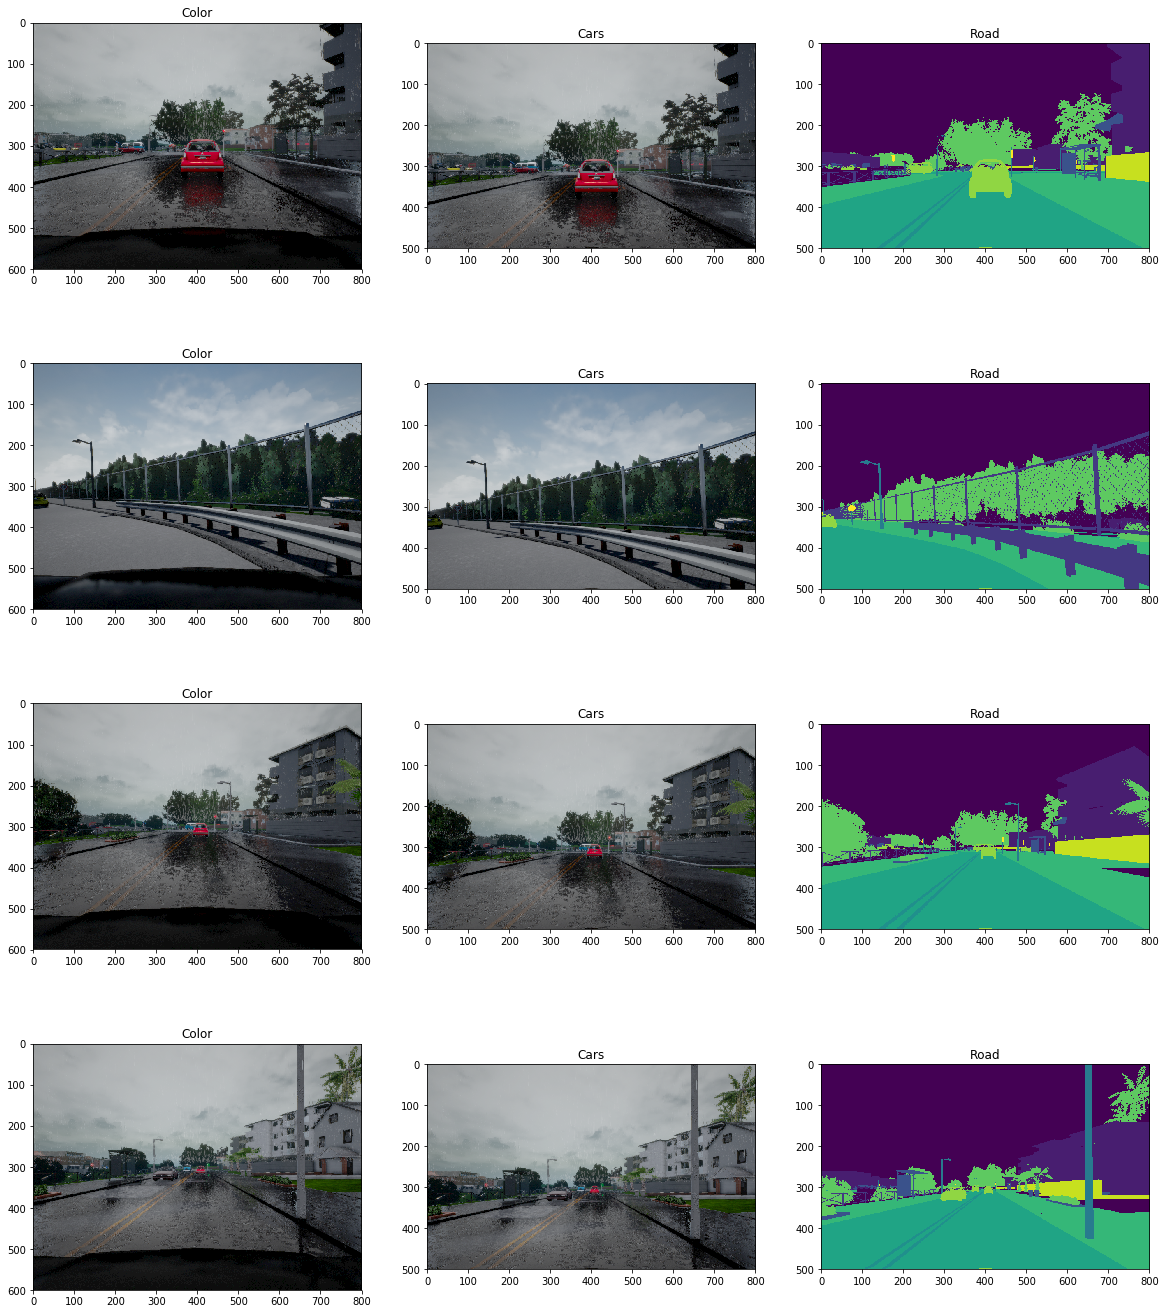

In [5]:
### print(clara_seg_data.shape[0], 'rows')
sample_rows = 4
fig, m_axs = plt.subplots(sample_rows, 3, figsize = (20, 6*sample_rows))
# [c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2, ax3), (_, c_row) in zip(m_axs, clara_seg_data.sample(sample_rows).iterrows()):
    c_img = imread(c_row['image'])
    
    c_img2 = c_img[:500, :, :]
    l_img = imread(c_row['label'])
    l_img = l_img[:500, :, 0]
    
    lbls = np.zeros_like(l_img)
    lbls[l_img == 10] = 1
    lbls[l_img == 7] = 2
    
    ax1.imshow(c_img)
    ax1.set_title('Color')    
    ax2.imshow(c_img2)
    ax2.set_title('Cars')
    ax3.imshow(l_img)
    ax3.set_title('Road')

In [6]:
IMG_SIZE = (480, 480) # slightly smaller than vgg16 normally expects


def process_label(lbl):
    new_lbl = np.zeros((*IMG_SIZE, 3))
    new_lbl[:, :, 0] = lbl[:, :, 0] == 7
    new_lbl[:400, :, 1] = lbl[:400, :, 0] == 10
    new_lbl[:, :, 2] = np.invert(np.logical_or(new_lbl[:, :, 0], new_lbl[:, :, 1]))
    
    return new_lbl

img_gen_args = dict(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.1, 
                              width_shift_range = 0.1, 
                              rotation_range = 3, 
                              shear_range = 0.01,
                              fill_mode = 'nearest',
                              zoom_range = 0.05)



rgb_gen = ImageDataGenerator(preprocessing_function = preprocess_input, **img_gen_args)
lab_gen = ImageDataGenerator(preprocessing_function=process_label, **img_gen_args)

In [7]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, seed = None, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])    
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, class_mode = 'sparse',seed = seed,**dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [8]:
def train_and_lab_gen_func(in_df, batch_size = 8, seed = None):
    if seed is None:
        seed = np.random.choice(range(1000))
    
    train_rgb_gen = flow_from_dataframe(rgb_gen, 
                                        in_df, 
                                        path_col = 'image',
                                        y_col = 'id', 
                                        color_mode = 'rgb',
                                        target_size = IMG_SIZE,
                                        batch_size = batch_size,
                                        seed = seed)
    
    train_lab_gen = flow_from_dataframe(lab_gen, 
                                        in_df, 
                                        path_col = 'label',
                                        y_col = 'id', 
                                        target_size = IMG_SIZE,
                                        color_mode = 'rgb',
                                        batch_size = batch_size,
                                        seed = seed)
    
    for (x, _), (y, _) in zip(train_rgb_gen, train_lab_gen):
        yield x, y
    
train_and_lab_gen = train_and_lab_gen_func(train_df, batch_size = 32)
valid_and_lab_gen = train_and_lab_gen_func(valid_df, batch_size = 32)


## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 800 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 800 images


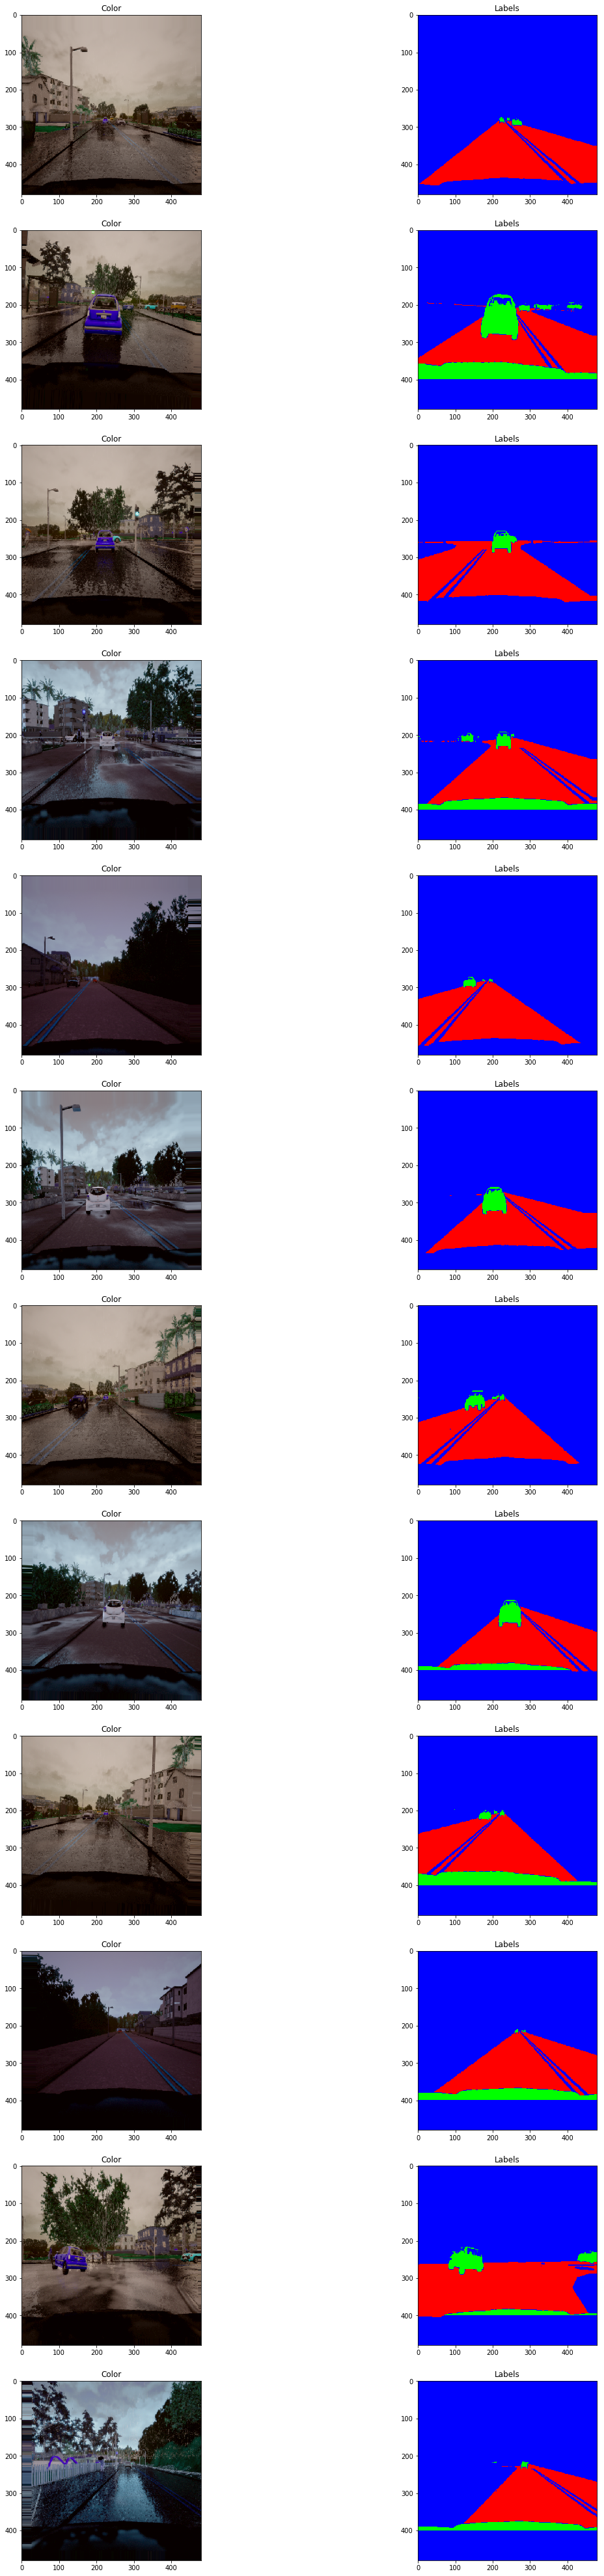

In [9]:
(rgb_batch, lab_batch) = next(train_and_lab_gen)

sample_rows = 12
fig, m_axs = plt.subplots(sample_rows, 2, figsize = (20, 6*sample_rows))
# [c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2), rgb_img, lab_img in zip(m_axs, rgb_batch, lab_batch):
    # undoing the vgg correction is tedious
    r_rgb_img = np.clip(rgb_img+110, 0, 255).astype(np.uint8)
    ax1.imshow(r_rgb_img)
    ax1.set_title('Color')
    ax2.imshow(lab_img)
    ax2.set_title('Labels')

In [10]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(480, 480, 3))

for layer in base_model.layers:
    layer.trainable = False

nClasses = 3

block3_pool = base_model.get_layer('block3_pool').output
block4_pool = base_model.get_layer('block4_pool').output
block5_pool = base_model.get_layer('block5_pool').output

conv_name_base = "block%d_conv%d"
pool_name_base = "block%d_pool"
dropout_name_base = "block%d_dropout"

block = 6
step = 1

X = Conv2D(4096, (7, 7),  padding='same', activation='relu', name='block6_conv1')(block5_pool)
X = Dropout(0.5, name='block6_dropout1')(X)
X = Conv2D(4096, (1, 1), activation='relu', padding='same', name='block6_conv2')(X)
X = Dropout(0.5, name='block6_dropout2')(X)
X = Conv2D(nClasses, (1, 1), padding='same', kernel_initializer='he_normal', name='block6_conv3')(X)
X = Conv2DTranspose(nClasses, kernel_size=(4,4), strides=(2,2) , padding='same', use_bias=False, name='block6_deconv1')(X)

X2 = Conv2D(nClasses, (1, 1), kernel_initializer='he_normal', padding='same', name='block7_conv1')(block4_pool)
# X2 = Cropping2D(cropping=((0, 1), (0, 0)))(X2)
X = Add(name='block7_Add')([X, X2])
X = Conv2DTranspose(nClasses, kernel_size=(4,4), strides=(2, 2), padding='same')(X)

X3 = Conv2D(nClasses, (1, 1), padding='same', name='block8_conv1')(block3_pool)
# X3 = Cropping2D(cropping=((0, 3), (0, 0)))(X3)
X = Add(name='block8_Add')([X, X3])
X = Conv2DTranspose(nClasses, kernel_size=(16, 16), strides=(8, 8), padding='same', name='block8_Deconv')(X)

# X = (Reshape((-1, nClasses)))(X)
X = (Activation('softmax'))(X)

model = Model(inputs = [base_model.input], outputs=[X])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 480, 480, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 480, 480, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 480, 480, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 240, 240, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [14]:
model.compile(loss='categorical_crossentropy',
      optimizer= 'adam' ,
      metrics=['accuracy'])

In [15]:
weight_path="{}_weights.best.hdf5".format('fcn8_vgg16')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

callbacks_list = [checkpoint]

In [17]:
batch_size = 16

train_and_lab_gen = train_and_lab_gen_func(train_df, batch_size = batch_size)
valid_and_lab_gen = train_and_lab_gen_func(valid_df, batch_size = batch_size)

history = model.fit_generator(train_and_lab_gen, 
                    steps_per_epoch = 800//batch_size,
                    validation_data = valid_and_lab_gen,
                    validation_steps = 200//batch_size,
                    epochs = 10, 
                    workers = 4,
                    use_multiprocessing = True,
                    callbacks = callbacks_list
                    )

/home/faisal/anaconda3/envs/ai/lib/python3.6/site-packages/keras/engine/training.py:2095: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


## Ignore next message from keras, values are replaced anyways
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
## Ignore next message from keras, values are replaced anyways
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
## Ignore next message from keras, values are replaced anyways
## Ignore next message from keras, values are replaced anyways
Reinserting dataframe: 200 images
Found 0 images belonging to 0 classes.
## Ignore next message from keras, values are replaced anyways
Reinserting dataframe: 200 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
Reinserting dataframe: 200 images
## Ignore next message from keras, values are replaced anyways
## Ignore next message from keras, values are replaced any

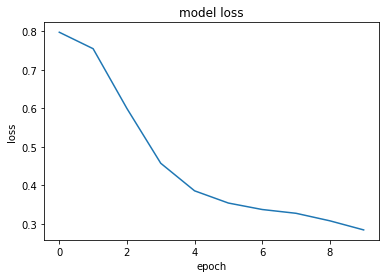

In [18]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
model.load_weights('fcn8_vgg16_weights.best.hdf5')

(rgb_batch, lab_batch) = next(valid_and_lab_gen)

sample_rows = 12
fig, m_axs = plt.subplots(sample_rows, 3, figsize = (20, 6*sample_rows))
# [c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2, ax3), rgb_img, lab_img in zip(m_axs, rgb_batch, lab_batch):
    # undoing the vgg correction is tedious
    r_rgb_img = np.clip(rgb_img+110, 0, 255).astype(np.uint8)
    lab_pred = model.predict(np.expand_dims(rgb_img, 0))[0]
    ax1.imshow(r_rgb_img)
    ax1.set_title('Color')
    ax2.imshow(lab_img)
    ax2.set_title('Labels')
    ax3.imshow(lab_pred)
    ax3.set_title('Predicted')

NameError: name 'model' is not defined